## Previsão de readmissão hospitalar utilizando modelo de Deep Learning

### por Antonildo Santos 

### Introdução
O objetivo desta análise é criar um modelo de Rede Neural Profunda (Deep Learning) capaz prever, com o mais alto grau de precisão possível, os atendimentos propícios a ocorrência de Readmissão Hospitalar.

### Apresentação dos dados

Para realizar este trabalho utilizei um conjunto de dados disponível publicamente no repositório da UCI [Link]( https://archive.ics.uci.edu/ml/datasets/diabetes+130-us+hospitals+for+years+1999-2008# ). Este conjunto de dados representa 10 anos (1999-2008) de atendimento clínico em 130 hospitais dos EUA, contendo 101.766 observações em 10 anos. Inclui mais de 50 atributos, que representam características do paciente, diagnósticos, exames, etc. As informações foram extraídas do banco de dados contendo registros que satisfizeram os seguintes critérios. 
 
* 1) Cada atendimento representa uma internação hospitalar. 
* 2) Contempla apenas atendimentos de pacientes diabéticos, ou seja, aquele em que qualquer tipo de diabetes foi introduzido no sistema como um diagnóstico. 
* 3) O tempo de permanência foi de no mínimo 1 dia e no máximo 14 dias. 
* 4) Testes laboratoriais foram realizados durante o atendimento. 
* 5) Medicamentos foram administrados durante o atendimento.
 
Os dados contêm atributos como número do paciente, raça, gênero, idade, tipo de internação, tempo no hospital, número de exames laboratoriais realizados, resultado do exame de HbA1c, diagnósticos, número de medicamentos utilizados, se usa medicamentos para diabético e quais, número de pacientes ambulatoriais , internação e visitas de emergência no ano anterior à hospitalização, etc. Alguns desses atributos serão desconsiderados nesta análise pois não terão relevância para o objetivo do trabalho.


###  Importando bibliotecas

In [1675]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
import time
import matplotlib.pyplot as plt
import seaborn as sns  
import matplotlib as mpl
from IPython.display import Image
from sklearn.metrics import mean_squared_error
#import seaborn as sns   
import warnings

%matplotlib inline

### Carga de dados

In [ ]:
# Carregando a base de dados
df_uci_diabetic = pd.read_csv('diabetic_data.csv', decimal=b',')

# Criando um novo dataframe a partir do df_uci_diabetic
df = df_uci_diabetic.copy (deep = True)

### Análise Exploratória

In [ ]:
print('O Dataframe diabetic_data possui ' + str(df.shape[0]) + ' linhas e ' + str(df.shape[1]) + ' colunas')

In [ ]:
# examinar os tipos de dados e estatísticas descritivas 
print (df.info ()) 
print (df.describe ())

In [ ]:
# Visualizando as primeiras 10 linhas do dataframe
df.head(10)

In [ ]:
df.describe()

In [ ]:
# Verificando a existencia de dados missing (dados faltantes)
for col in df.columns:
    if df[col].dtype == object:
        if df[col][df[col] == '?'].count() > 0:
            print(col,df[col][df[col] == '?'].count(),' Correspondendo a ',np.around((df[col][df[col] == '?'].count()/df[col].count())*100,2), '% das observações')

In [ ]:
# Avaliando a distribuição dos dados em cada atributo
for col in df.columns:
    if df[col].dtype == object:
        if df[col][df[col] == '?'].count() != 0:       
            print(df.groupby([col])[col].count())
            print('')

In [ ]:
# Avaliando a distribuição dos dados em cada atributo
for col in df.columns:
    if df[col].dtype == object:
        if df[col][df[col] == '?'].count() == 0:       
            print(df.groupby([col])[col].count())
            print('')

In [ ]:
# Verificando a mediana
for col in df.columns:
    if df[col].dtype != object:
        print(col, df[col].median())
        print('')

### Limpeza e Transformação dos dados

Os critérios de eliminação de atributos e observações depende muito da interpretação dos dados feita pelo Cientista de Dados na fase de exploração. Estes critérios passam pela avaliação de cada atributo do conjunto de dados, verificação da distribuição de frequência, analise de correlações entre variáveis, modelo preditivo que será aplicado, além de um certo conhecimento do negócio em estudo, para então decidir quais a tributos e/ou observações devem ser descartados. Considerando o conjunto de dados em questão, decidi eliminar alguns atributos nos quais avalio que não impactará no resultado das análises preditivas. Descartarei os atributos "encounter_id", "patient_nbr", "weight", "payer_code", "examide", "citoglipton" e "medical_specialty". Por exemplo o atributo "weight", que corresponde ao peso do paciente, seria um atributo muito importante a ser considerado na análise, porém em 97% das observação este atributo está sem valor, tornando-se um dado insuficientemente consistente para o modelo aplicar algum tipo de generalização.

Com base na consulta a documentação disponibilizada pelo repositório dos dados e entendimento de cada atributo do conjunto de dados, decidi também eliminar algumas observações que acredito não impactar no objetivo proposta neste trabalho. Precisarei também transformar alguns dados, com o objetivo de prepará-los para serem entregue ao modelo preditivo proposto.

In [ ]:
# Eliminando colunas que não serão utilizadas
df.drop(['encounter_id', 'patient_nbr', 'weight', 'payer_code', 'examide', 'citoglipton', 'medical_specialty'], axis = 1, inplace = True)

#### Categorização de diagnósticos
No conjunto de dados existem três diagnosticos, um principal e dois secundários, contendo em média 752 codigos distintos em cada um, por isso resolvi realizar um reagrupamento com base numa análise realizada por Strack et al. em 2014, sobre o mesmo tema e utilizando o mesmo conjunto de dados, publicado em ( https://www.hindawi.com/journals/bmri/2014/781670/abs/ ). 

In [ ]:
Image('Agrupamento_CID_9.png')

In [ ]:
# Criando novas colunas para atribuir os valores transformados
df['d1'] = df['diag_1']
df['d2'] = df['diag_2']
df['d3'] = df['diag_3']
df['classe'] = -1
df['change_t'] = -1
df['gender_t'] = -1
df['diabetesMed_t'] = -1

In [ ]:
# Reagrupamento do diagnóstico principal
df['d1'] = df.apply(lambda row: 1 if (row['diag_1'][0:3].zfill(3) >= '390') and (row['diag_1'][0:3].zfill(3) <= '459' ) or  (row['diag_1'][0:3].zfill(3) == '785' ) else row['d1'], axis=1)
df['d1'] = df.apply(lambda row: 2 if (row['diag_1'][0:3].zfill(3) >= '460') and (row['diag_1'][0:3].zfill(3) <= '519' ) or  (row['diag_1'][0:3].zfill(3) == '786' ) else row['d1'], axis=1)
df['d1'] = df.apply(lambda row: 3 if (row['diag_1'][0:3].zfill(3) >= '520') and (row['diag_1'][0:3].zfill(3) <= '579' ) or  (row['diag_1'][0:3].zfill(3) == '787' ) else row['d1'], axis=1)
df['d1'] = df.apply(lambda row: 4 if (row['diag_1'][0:3].zfill(3) == '250') else row['d1'], axis=1)
df['d1'] = df.apply(lambda row: 5 if (row['diag_1'][0:3].zfill(3) >= '800') and (row['diag_1'][0:3].zfill(3) <= '999' ) else row['d1'], axis=1)
df['d1'] = df.apply(lambda row: 6 if (row['diag_1'][0:3].zfill(3) >= '710') and (row['diag_1'][0:3].zfill(3) <= '739' ) else row['d1'], axis=1)
df['d1'] = df.apply(lambda row: 7 if (row['diag_1'][0:3].zfill(3) >= '580') and (row['diag_1'][0:3].zfill(3) <= '629' ) or  (row['diag_1'][0:3].zfill(3) == '788' ) else row['d1'], axis=1)
df['d1'] = df.apply(lambda row: 8 if (row['diag_1'][0:3].zfill(3) >= '140') and (row['diag_1'][0:3].zfill(3) <= '239' ) else row['d1'], axis=1)
df['d1'] = df.apply(lambda row: 9 if (row['diag_1'][0:3].zfill(3) >= '790') and (row['diag_1'][0:3].zfill(3) <= '799' ) or  (row['diag_1'][0:3].zfill(3) == '780' ) or  (row['diag_1'][0:3].zfill(3) == '781' ) or  (row['diag_1'][0:3].zfill(3) == '784' ) else row['d1'], axis=1)
df['d1'] = df.apply(lambda row: 10 if (row['diag_1'][0:3].zfill(3) >= '240') and (row['diag_1'][0:3].zfill(3) <= '249' ) else row['d1'], axis=1)
df['d1'] = df.apply(lambda row: 10 if (row['diag_1'][0:3].zfill(3) >= '251') and (row['diag_1'][0:3].zfill(3) <= '279' ) else row['d1'], axis=1)
df['d1'] = df.apply(lambda row: 11 if (row['diag_1'][0:3].zfill(3) >= '680') and (row['diag_1'][0:3].zfill(3) <= '709' ) or  (row['diag_1'][0:3].zfill(3) == '782' ) else row['d1'], axis=1)
df['d1'] = df.apply(lambda row: 12 if (row['diag_1'][0:3].zfill(3) >= '001') and (row['diag_1'][0:3].zfill(3) <= '139' ) else row['d1'], axis=1)
df['d1'] = df.apply(lambda row: 13 if (row['diag_1'][0:3].zfill(3) >= '290') and (row['diag_1'][0:3].zfill(3) <= '319' ) else row['d1'], axis=1)
df['d1'] = df.apply(lambda row: 13 if (row['diag_1'][0:1] >= 'E') and (row['diag_1'][0:1] <= 'V' ) else row['d1'], axis=1)
df['d1'] = df.apply(lambda row: 13 if (row['diag_1'][0:3].zfill(3) >= '280') and (row['diag_1'][0:3].zfill(3) <= '289' ) else row['d1'], axis=1)
df['d1'] = df.apply(lambda row: 13 if (row['diag_1'][0:3].zfill(3) >= '320') and (row['diag_1'][0:3].zfill(3) <= '359' ) else row['d1'], axis=1)
df['d1'] = df.apply(lambda row: 13 if (row['diag_1'][0:3].zfill(3) >= '630') and (row['diag_1'][0:3].zfill(3) <= '679' ) else row['d1'], axis=1)
df['d1'] = df.apply(lambda row: 13 if (row['diag_1'][0:3].zfill(3) >= '360') and (row['diag_1'][0:3].zfill(3) <= '389' ) else row['d1'], axis=1)
df['d1'] = df.apply(lambda row: 13 if (row['diag_1'][0:3].zfill(3) >= '740') and (row['diag_1'][0:3].zfill(3) <= '759' ) else row['d1'], axis=1)
df['d1'] = df.apply(lambda row: 0 if (row['diag_1'][0:3].zfill(3)  == '783' or row['diag_1'][0:3].zfill(3)  == '789') else row['d1'], axis=1)
df['d1'] = df.apply(lambda row: -1 if (row['diag_1'][0:1] == '?') else row['d1'], axis=1)                           

In [ ]:
# Reagrupamento do primeiro diagnóstico secundário
df['d2'] = df.apply(lambda row: 1 if (row['diag_2'][0:3].zfill(3) >= '390') and (row['diag_2'][0:3].zfill(3) <= '459' ) or  (row['diag_2'][0:3].zfill(3) == '785' ) else row['d2'], axis=1)
df['d2'] = df.apply(lambda row: 2 if (row['diag_2'][0:3].zfill(3) >= '460') and (row['diag_2'][0:3].zfill(3) <= '519' ) or  (row['diag_2'][0:3].zfill(3) == '786' ) else row['d2'], axis=1)
df['d2'] = df.apply(lambda row: 3 if (row['diag_2'][0:3].zfill(3) >= '520') and (row['diag_2'][0:3].zfill(3) <= '579' ) or  (row['diag_2'][0:3].zfill(3) == '787' ) else row['d2'], axis=1)
df['d2'] = df.apply(lambda row: 4 if (row['diag_2'][0:3].zfill(3) == '250') else row['d2'], axis=1)
df['d2'] = df.apply(lambda row: 5 if (row['diag_2'][0:3].zfill(3) >= '800') and (row['diag_2'][0:3].zfill(3) <= '999' ) else row['d2'], axis=1)
df['d2'] = df.apply(lambda row: 6 if (row['diag_2'][0:3].zfill(3) >= '710') and (row['diag_2'][0:3].zfill(3) <= '739' ) else row['d2'], axis=1)
df['d2'] = df.apply(lambda row: 7 if (row['diag_2'][0:3].zfill(3) >= '580') and (row['diag_2'][0:3].zfill(3) <= '629' ) or  (row['diag_2'][0:3].zfill(3) == '788' ) else row['d2'], axis=1)
df['d2'] = df.apply(lambda row: 8 if (row['diag_2'][0:3].zfill(3) >= '140') and (row['diag_2'][0:3].zfill(3) <= '239' ) else row['d2'], axis=1)
df['d2'] = df.apply(lambda row: 9 if (row['diag_2'][0:3].zfill(3) >= '790') and (row['diag_2'][0:3].zfill(3) <= '799' ) or  (row['diag_2'][0:3].zfill(3) == '780' ) or  (row['diag_2'][0:3].zfill(3) == '781' ) or  (row['diag_2'][0:3].zfill(3) == '784' ) else row['d2'], axis=1)
df['d2'] = df.apply(lambda row: 10 if (row['diag_2'][0:3].zfill(3) >= '240') and (row['diag_2'][0:3].zfill(3) <= '249' ) else row['d2'], axis=1)
df['d2'] = df.apply(lambda row: 10 if (row['diag_2'][0:3].zfill(3) >= '251') and (row['diag_2'][0:3].zfill(3) <= '279' ) else row['d2'], axis=1)
df['d2'] = df.apply(lambda row: 11 if (row['diag_2'][0:3].zfill(3) >= '680') and (row['diag_2'][0:3].zfill(3) <= '709' ) or  (row['diag_2'][0:3].zfill(3) == '782' ) else row['d2'], axis=1)
df['d2'] = df.apply(lambda row: 12 if (row['diag_2'][0:3].zfill(3) >= '001') and (row['diag_2'][0:3].zfill(3) <= '139' ) else row['d2'], axis=1)
df['d2'] = df.apply(lambda row: 13 if (row['diag_2'][0:3].zfill(3) >= '290') and (row['diag_2'][0:3].zfill(3) <= '319' ) else row['d2'], axis=1)
df['d2'] = df.apply(lambda row: 13 if (row['diag_2'][0:1] >= 'E') and (row['diag_2'][0:1] <= 'V' ) else row['d2'], axis=1)
df['d2'] = df.apply(lambda row: 13 if (row['diag_2'][0:3].zfill(3) >= '280') and (row['diag_2'][0:3].zfill(3) <= '289' ) else row['d2'], axis=1)
df['d2'] = df.apply(lambda row: 13 if (row['diag_2'][0:3].zfill(3) >= '320') and (row['diag_2'][0:3].zfill(3) <= '359' ) else row['d2'], axis=1)
df['d2'] = df.apply(lambda row: 13 if (row['diag_2'][0:3].zfill(3) >= '630') and (row['diag_2'][0:3].zfill(3) <= '679' ) else row['d2'], axis=1)
df['d2'] = df.apply(lambda row: 13 if (row['diag_2'][0:3].zfill(3) >= '360') and (row['diag_2'][0:3].zfill(3) <= '389' ) else row['d2'], axis=1)
df['d2'] = df.apply(lambda row: 13 if (row['diag_2'][0:3].zfill(3) >= '740') and (row['diag_2'][0:3].zfill(3) <= '759' ) else row['d2'], axis=1)
df['d2'] = df.apply(lambda row: 0 if (row['diag_2'][0:3].zfill(3)  == '783' or row['diag_2'][0:3].zfill(3)  == '789') else row['d2'], axis=1)
df['d2'] = df.apply(lambda row: -1 if (row['diag_2'][0:1] == '?') else row['d2'], axis=1)                           

In [ ]:
# Reagrupamento do segundo diagnóstico secundário
df['d3'] = df.apply(lambda row: 1 if (row['diag_3'][0:3].zfill(3) >= '390') and (row['diag_3'][0:3].zfill(3) <= '459' ) or  (row['diag_3'][0:3].zfill(3) == '785' ) else row['d3'], axis=1)
df['d3'] = df.apply(lambda row: 2 if (row['diag_3'][0:3].zfill(3) >= '460') and (row['diag_3'][0:3].zfill(3) <= '519' ) or  (row['diag_3'][0:3].zfill(3) == '786' ) else row['d3'], axis=1)
df['d3'] = df.apply(lambda row: 3 if (row['diag_3'][0:3].zfill(3) >= '520') and (row['diag_3'][0:3].zfill(3) <= '579' ) or  (row['diag_3'][0:3].zfill(3) == '787' ) else row['d3'], axis=1)
df['d3'] = df.apply(lambda row: 4 if (row['diag_3'][0:3].zfill(3) == '250') else row['d3'], axis=1)
df['d3'] = df.apply(lambda row: 5 if (row['diag_3'][0:3].zfill(3) >= '800') and (row['diag_3'][0:3].zfill(3) <= '999' ) else row['d3'], axis=1)
df['d3'] = df.apply(lambda row: 6 if (row['diag_3'][0:3].zfill(3) >= '710') and (row['diag_3'][0:3].zfill(3) <= '739' ) else row['d3'], axis=1)
df['d3'] = df.apply(lambda row: 7 if (row['diag_3'][0:3].zfill(3) .zfill(3)>= '580') and (row['diag_3'][0:3].zfill(3) <= '629' ) or  (row['diag_3'][0:3].zfill(3) == '788' ) else row['d3'], axis=1)
df['d3'] = df.apply(lambda row: 8 if (row['diag_3'][0:3].zfill(3) >= '140') and (row['diag_3'][0:3].zfill(3) <= '239' ) else row['d3'], axis=1)
df['d3'] = df.apply(lambda row: 9 if (row['diag_3'][0:3].zfill(3) >= '790') and (row['diag_3'][0:3].zfill(3) <= '799' ) or  (row['diag_3'][0:3].zfill(3) == '780' ) or  (row['diag_3'][0:3].zfill(3) == '781' ) or  (row['diag_3'][0:3].zfill(3) == '784' ) else row['d3'], axis=1)
df['d3'] = df.apply(lambda row: 10 if (row['diag_3'][0:3].zfill(3) >= '240') and (row['diag_3'][0:3].zfill(3) <= '249' ) else row['d3'], axis=1)
df['d3'] = df.apply(lambda row: 10 if (row['diag_3'][0:3].zfill(3) >= '251') and (row['diag_3'][0:3].zfill(3) <= '279' ) else row['d3'], axis=1)
df['d3'] = df.apply(lambda row: 11 if (row['diag_3'][0:3].zfill(3) >= '680') and (row['diag_3'][0:3].zfill(3) <= '709' ) or  (row['diag_3'][0:3].zfill(3) == '782' ) else row['d3'], axis=1)
df['d3'] = df.apply(lambda row: 12 if (row['diag_3'][0:3].zfill(3) >= '001') and (row['diag_3'][0:3].zfill(3) <= '139' ) else row['d3'], axis=1)
df['d3'] = df.apply(lambda row: 13 if (row['diag_3'][0:3].zfill(3) >= '290') and (row['diag_3'][0:3].zfill(3) <= '319' ) else row['d3'], axis=1)
df['d3'] = df.apply(lambda row: 13 if (row['diag_3'][0:1] >= 'E') and (row['diag_3'][0:1] <= 'V' ) else row['d3'], axis=1)
df['d3'] = df.apply(lambda row: 13 if (row['diag_3'][0:3].zfill(3) >= '280') and (row['diag_3'][0:3].zfill(3) <= '289' ) else row['d3'], axis=1)
df['d3'] = df.apply(lambda row: 13 if (row['diag_3'][0:3].zfill(3) >= '320') and (row['diag_3'][0:3].zfill(3) <= '359' ) else row['d3'], axis=1)
df['d3'] = df.apply(lambda row: 13 if (row['diag_3'][0:3].zfill(3) >= '630') and (row['diag_3'][0:3].zfill(3) <= '679' ) else row['d3'], axis=1)
df['d3'] = df.apply(lambda row: 13 if (row['diag_3'][0:3].zfill(3) >= '360') and (row['diag_3'][0:3].zfill(3) <= '389' ) else row['d3'], axis=1)
df['d3'] = df.apply(lambda row: 13 if (row['diag_3'][0:3].zfill(3) >= '740') and (row['diag_3'][0:3].zfill(3) <= '759' ) else row['d3'], axis=1)
df['d3'] = df.apply(lambda row: 0 if (row['diag_3'][0:3].zfill(3)  == '783' or row['diag_3'][0:3].zfill(3)  == '789') else row['d3'], axis=1)
df['d3'] = df.apply(lambda row: -1 if (row['diag_3'][0:1] == '?') else row['d3'], axis=1)                           

In [ ]:
print(df.groupby(['d1', 'diag_1']).d2.count())

In [ ]:
print(df.groupby(['d2', 'diag_2']).d2.count())

In [ ]:
print(df.groupby(['d3', 'diag_3']).d3.count())

Conforme consta na documentação, trata-se de um do conjunto de dados contendo atendimentos onde qualquer tipo de diabetes foi introduzido no sistema como um diagnóstico, então eliminarei as observações onde não existe nenhum diagnóstico registrado.

In [ ]:
df = df[(df.d1 > -1) | (df.d2 > -1) | (df.d3 > -1)]

In [ ]:
# Eliminando as colunas originais do diagnósticos
df.drop(['diag_1'], axis = 1, inplace = True)
df.drop(['diag_2'], axis = 1, inplace = True)
df.drop(['diag_3'], axis = 1, inplace = True)

### Aplicando a transformação dos dados

In [ ]:
# Atribui a classe os valores 1 ou 0, correspondendo a ocorrencias de readmissão em menos de 30 dias ou não 
df['classe'] = df.apply(lambda row: 0 if (row['readmitted'][0:3] == '>30' or row['readmitted'][0:2] == 'NO') else row['classe'], axis=1) 
df['classe'] = df.apply(lambda row: 1 if (row['readmitted'][0:3] == '<30') else row['classe'], axis=1)
df.drop(['readmitted'], axis = 1, inplace = True)

In [ ]:
df['change_t'] = df.apply(lambda row: 1 if (row['change'] == 'Ch') else -1, axis=1)
df['change_t'] = df.apply(lambda row: 0 if (row['change'] == 'No') else row['change_t'], axis=1)
df.drop(['change'], axis = 1, inplace = True)

In [ ]:
df['gender_t'] = df.apply(lambda row: 1 if (row['gender'] == 'Male') else -1, axis=1)
df['gender_t'] = df.apply(lambda row: 0 if (row['gender'] == 'Female') else row['gender_t'], axis=1)
df.drop(['gender'], axis = 1, inplace = True)

In [ ]:
df['diabetesMed_t'] = df.apply(lambda row: 1 if (row['diabetesMed'] == 'Yes') else -1, axis=1)
df['diabetesMed_t'] = df.apply(lambda row: 0 if (row['diabetesMed'] == 'No') else row['diabetesMed_t'], axis=1)
df.drop(['diabetesMed'], axis = 1, inplace = True)

In [ ]:
m = 0
medicacoes = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide', 
              'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'insulin', 'glyburide-metformin', 'tolazamide', 
              'metformin-pioglitazone','metformin-rosiglitazone', 'glimepiride-pioglitazone', 
              'glipizide-metformin', 'troglitazone', 'tolbutamide', 'acetohexamide']
for col in df.columns:
    if col in medicacoes:       
        colname = 'Med' + str(m) + '_t'
        df[colname] = df.apply(lambda row: 0 if (row[col] == 'No') else 1, axis=1)
        df.drop([col], axis = 1, inplace = True)
        m = m + 1

In [ ]:
df['A1Cresult_t'] = df.apply(lambda row: 0 if (row['A1Cresult'][0:4] == 'Norm') else -1, axis=1) 
df['A1Cresult_t'] = df.apply(lambda row: 1 if (row['A1Cresult'][0:2] == '>7' or row['A1Cresult'][0:2] == '>8') else row['A1Cresult_t'], axis=1) 
df.drop(['A1Cresult'], axis = 1, inplace = True)

In [ ]:
df['max_glu_serum_t'] = df.apply(lambda row: 0 if (row['max_glu_serum'][0:4] == 'Norm') else -1, axis=1) 
df['max_glu_serum_t'] = df.apply(lambda row: 1 if (row['max_glu_serum'][0:2] == '>7' or row['max_glu_serum'][0:2] == '>8') else row['max_glu_serum_t'], axis=1) 
df.drop(['max_glu_serum'], axis = 1, inplace = True)

In [ ]:
df['age_faixa'] = df.apply(lambda row: 0 if (row['age'] == '[0-10)') else -1, axis=1) 
df['age_faixa'] = df.apply(lambda row: 1 if (row['age'] == '[10-20)') else row['age_faixa'], axis=1)
df['age_faixa'] = df.apply(lambda row: 2 if (row['age'] == '[20-30)') else row['age_faixa'], axis=1) 
df['age_faixa'] = df.apply(lambda row: 3 if (row['age'] == '[30-40)') else row['age_faixa'], axis=1)
df['age_faixa'] = df.apply(lambda row: 4 if (row['age'] == '[40-50)') else row['age_faixa'], axis=1) 
df['age_faixa'] = df.apply(lambda row: 5 if (row['age'] == '[50-60)') else row['age_faixa'], axis=1)
df['age_faixa'] = df.apply(lambda row: 6 if (row['age'] == '[70-80)') else row['age_faixa'], axis=1) 
df['age_faixa'] = df.apply(lambda row: 7 if (row['age'] == '[80-90)') else row['age_faixa'], axis=1)
df['age_faixa'] = df.apply(lambda row: 8 if (row['age'] == '[90-100)') else row['age_faixa'], axis=1)
df.drop(['age'], axis = 1, inplace = True)

In [ ]:
df['race_t'] = df.apply(lambda row: 0 if (row['race'] == '?') else -1, axis=1) 
df['race_t'] = df.apply(lambda row: 1 if (row['race'] == 'AfricanAmerican') else row['race_t'], axis=1)
df['race_t'] = df.apply(lambda row: 2 if (row['race'] == 'Asian') else row['race_t'], axis=1) 
df['race_t'] = df.apply(lambda row: 3 if (row['race'] == 'Caucasian') else row['race_t'], axis=1)
df['race_t'] = df.apply(lambda row: 4 if (row['race'] == 'Hispanic') else row['race_t'], axis=1) 
df['race_t'] = df.apply(lambda row: 5 if (row['race'] == 'Other') else row['race_t'], axis=1)
df.drop(['race'], axis = 1, inplace = True)

In [ ]:
# Salvando o dataset com as tranformações realizadas
df.to_csv('./diabetes_data_modificado.csv', index=False)

In [1670]:
# Carregando a base de dados
df = pd.read_csv('diabetes_data_modificado.csv', decimal=b',')

In [ ]:
df.head(10)

In [ ]:
print (df.info ()) 

In [ ]:
print(df.groupby(['classe']).classe.count())

### Construção do Modelo Preditivo

O indicador de Readmissão Hospitalar  mede a taxa de pacientes que retornaram ao hospital em até 30 dias desde a última alta hospitalar correspondente a primeira admissão. Este indicador avalia a capacidade progressiva do prestador de serviço em ajudar na recuperação do paciente. Nos Estados unidos, várias iniciativas já foram tomadas para garantir o sucesso da recuperação da saúde de seus pacientes, usando técnicas de trabalho em equipe a tecnologia para diminuir a readmissão hospitalar.

A taxa de readmissão hospitalar é frequentemente usada como uma medida da qualidade assistencial de um hospital, segundo determina a ANS, o indicador de Readmissão Hospitalar é um dos critérios para o estabelecimento alcançar o reajuste de 100% do IPCA, consequentemente uma alta taxa de readmissão pode afetar o índice de reajuste dos contratos firmados entre operadoras de planos de saúde e prestadores de serviço. Segundo a diretora-adjunta de Desenvolvimento Setorial da ANS, Michelle Mello “Esse é um indicador internacional clássico para avaliação da qualidade de atendimento e cuidado prestados ao paciente nos hospitais. Quanto menor for a reincidência de internação, ou seja, quanto menor for a readmissão potencialmente evitável, melhor é considerado o atendimento prestado pela unidade hospitalar”.

Um dos grandes desafios dos hospitais é identificar as readmissões que poderiam ser evitadas. Ser capaz de prever quais pacientes serão readmitidos pode ajudar os hospitais e operadoras de plano de saúde a economizar milhões de reais e melhorar a qualidade dos cuidados e recuperação dos pacientes

O objetivo deste trabalhe é implementar um modelo de Deep Learning, capaz de classificar os pacientes que serão readmitidos, com o mais alto grau de precisão possível. Um dos desafios ao analisar este conjunto de dados é o enorme desequilíbrio da variável target: as readmissões com menos de 30 dias correspondem apenas 11,16% dos atendimentos. Nesse caso, é muito pior ter falsos negativos do que falsos positivos em nossas previsões, pois falsos negativos significam que algum paciente foi readmitido, porém o modelo não foi capaz de prever, isso poderá comprometer os idicadores de qualidade da instituição. 

In [4]:
# Pacotes de Manipulação de Dados
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.model_selection import KFold

# Keras e TensorFlow

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD, Adam
import tensorflow as tf

# Pacotes para Confusion Matrix e Balanceamento de Classes
import pandas_ml as pdml
import imblearn
from imblearn.combine import SMOTETomek


C:\Users\anton\Anaconda3\envs\theano\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


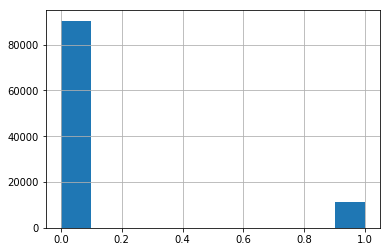

In [5]:
df['classe'].hist()
plt.show()

In [367]:
print('O Dataframe diabetic_data_modificado possui ' + str(df.shape[0]) + ' linhas e ' + str(df.shape[1]) + ' colunas')

O Dataframe diabetic_data_modificado possui 101765 linhas e 43 colunas


In [1884]:
readmissoes = df.loc[df['classe'] == 1]
nao_readmissoes = df.loc[df['classe'] == 0]
print("Temos", len(readmissoes), "pontos de dados como readmissões e", len(nao_readmissoes), "pontos de dados considerados normais.")

Temos 11357 pontos de dados como readmissões e 90408 pontos de dados considerados normais.


In [1820]:
# Atribuido valores as variáveis X e y do dodelo
X = df.iloc[:,:-1]
y = df['classe']

# Gerando dados de treino, teste e validação
X1, X_valid, y1, y_valid = train_test_split(X, y.as_matrix(), test_size = 0.15, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size = 0.25, random_state = 52)

In [1101]:
print("Tamanho do Dataset de Treino: ", X_train.shape)

Tamanho do Dataset de Treino:  (64875, 42)


In [1102]:
print("Tamanho do Dataset de Validaçao: ", X_valid.shape)

Tamanho do Dataset de Validaçao:  (15265, 42)


In [1103]:
print("Tamanho do Dataset de Test: ", X_test.shape)

Tamanho do Dataset de Test:  (21625, 42)


### Começando com uma Rede Neural Simples

In [370]:
model = Sequential()
model.add(Dense(42, input_dim = 42, activation = 'relu'))     
model.add(Dense(1, activation = 'sigmoid'))                
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_199 (Dense)            (None, 42)                1806      
_________________________________________________________________
dense_200 (Dense)            (None, 1)                 43        
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________


In [371]:
model.fit(X_train.as_matrix(), y_train, epochs = 1, validation_data=(X_valid, y_valid))

Train on 64875 samples, validate on 15265 samples
Epoch 1/1
64875/64875 [==============================] - 12s 189us/step - loss: 0.1002 - acc: 0.9700 - val_loss: 0.0057 - val_acc: 1.0000


In [372]:
print("Erro/Acurácia: ", model.evaluate(X_valid.as_matrix(), y_valid, verbose = 0))

Erro/Acurácia:  [0.0056799375555208675, 1.0]


In [373]:
y_predicted = model.predict(X_valid.as_matrix()).T[0].astype(int)

Confusion matrix:
Predicted      0  1  __all__
Actual                      
0          13560  0    13560
1           1705  0     1705
__all__    15265  0    15265


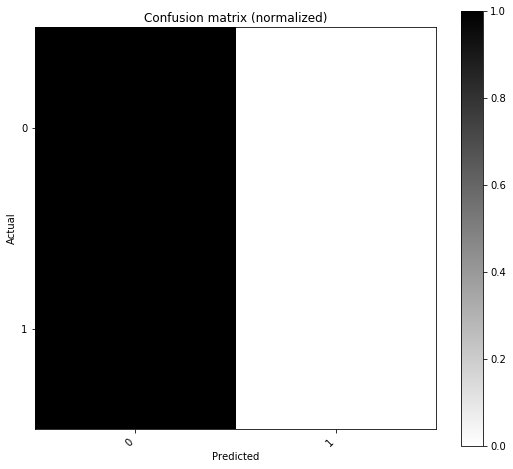

Confusion Matrix:

Predicted      0  1  __all__
Actual                      
0          13560  0    13560
1           1705  0     1705
__all__    15265  0    15265


Overall Statistics:

Accuracy: 0.8883065836881756
95% CI: (0.883202818959111, 0.8932618369543117)
No Information Rate: ToDo
P-Value [Acc > NIR]: 1.0
Kappa: 0.0
Mcnemar's Test P-Value: ToDo


Class Statistics:

Classes                                       0         1
Population                                15265     15265
P: Condition positive                     13560      1705
N: Condition negative                      1705     13560
Test outcome positive                     15265         0
Test outcome negative                         0     15265
TP: True Positive                         13560         0
TN: True Negative                             0     13560
FP: False Positive                         1705         0
FN: False Negative                            0      1705
TPR: (Sensitivity, hit rate, recall)        

In [374]:
from pandas_ml import ConfusionMatrix
import warnings
warnings.filterwarnings('ignore')
y_right = np.array(y_valid)
confusion_matrix = ConfusionMatrix(y_right, y_predicted)
print("Confusion matrix:\n%s" % confusion_matrix)
confusion_matrix.plot(normalized=True)
plt.show()
confusion_matrix.print_stats()

Podemos observar que apesar do modelo está demonstrando uma acurácia de aproximadamente 88%, analisando a ConfusionMatrix percebemos que os resultados não foram satisfatório, consequencia do desbalanciamento dos dados. Então vamos aplicar um oversampling para corrigir um viés no conjunto de dados original, empregando Synthetic Minority Over-sampling Technique para balancear os dados. 

### Aplicando Scala, Oversampling e Redução de dimensionalidade com PCA

In [1822]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer, Normalizer, StandardScaler, MaxAbsScaler, RobustScaler


df2 = pdml.ModelFrame(X_train, target=y_train.ravel())
ampler = SMOTETomek(random_state=42, ratio='auto')
oversampled = df2.fit_sample(sampler)
X2_train, y2_train = oversampled.iloc[:,1:], oversampled.iloc[:,0]
X2_train
data = scale(X2_train)
pca = PCA(n_components = 10)
X2_train = pca.fit_transform(data)
data = scale(X_valid)
pca = PCA(n_components = 10)
X_valid = pca.fit_transform(data)
data = scale(X_test)
pca = PCA(n_components = 10)
X_test = pca.fit_transform(data)
X2_train

array([[ 1.13704718, -1.9136966 , -1.94068702, ..., -0.92719112,
         2.5924661 ,  0.93507925],
       [ 3.33408314,  1.30404   , -1.3666474 , ..., -0.63433479,
         0.46784048,  0.65992375],
       [ 0.39415854, -3.01687182, -2.26766923, ...,  2.26787175,
        -0.07146902,  0.42011434],
       ...,
       [ 1.53405637, -1.87830753,  1.6465928 , ...,  0.36178118,
         1.19159827, -0.9396254 ],
       [-0.67543362,  2.08649192, -0.49076992, ..., -0.54896311,
        -0.67509356,  0.14076616],
       [-1.05886019, -0.99912696, -0.25573581, ...,  0.85162891,
         0.59529961,  0.09479871]])

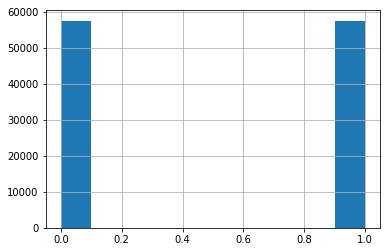

In [1823]:
oversampled.iloc[:,0].hist()
plt.show()

### Aumentando o Número de Camadas na Rede Neural

In [377]:
from keras.callbacks import EarlyStopping

In [1868]:
OPTIMIZER = Adam(lr=0.001, beta_1=0.99, beta_2=0.999, amsgrad=True) # otimizador

In [ ]:
batch_size = 6490

In [1870]:
model2 = Sequential()
model2.add(Dense(10, input_dim = 10, kernel_initializer='ones', activation = 'relu')) 
model2.add(Dropout(0.25))
model2.add(Dense(64, kernel_initializer='ones', activation = 'tanh'))
model2.add(Dropout(0.25))
model2.add(Dense(16, kernel_initializer='ones', activation = 'tanh'))
model2.add(Dropout(0.25))
model2.add(Dense(8, kernel_initializer='ones', activation = 'tanh'))
model2.add(Dropout(0.25))
model2.add(Dense(4, kernel_initializer='ones', activation = 'tanh'))
model2.add(Dropout(0.15))
model2.add(Dense(2, kernel_initializer='ones', activation = 'tanh'))
model2.add(Dropout(0.15))
model2.add(Dense(1, kernel_initializer='ones', activation = 'sigmoid'))
monitor = EarlyStopping(monitor = 'val_loss', min_delta = 1e-3, patience = 5, verbose = 1, mode = 'auto')   
model2.compile(loss = 'binary_crossentropy', optimizer = OPTIMIZER, metrics = ['accuracy'])
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1068 (Dense)           (None, 10)                110       
_________________________________________________________________
dropout_912 (Dropout)        (None, 10)                0         
_________________________________________________________________
dense_1069 (Dense)           (None, 64)                704       
_________________________________________________________________
dropout_913 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_1070 (Dense)           (None, 16)                1040      
_________________________________________________________________
dropout_914 (Dropout)        (None, 16)                0         
_________________________________________________________________
dense_1071 (Dense)           (None, 8)                 136       
__________

In [1871]:
history = model2.fit(X2_train, y2_train, epochs = 100, batch_size=batch_size, validation_data=(X_valid, y_valid), callbacks = [monitor], shuffle=False)

Train on 115190 samples, validate on 15265 samples
Epoch 1/100
115190/115190 [==============================] - 14s 124us/step - loss: 1.0379 - acc: 0.5568 - val_loss: 0.9329 - val_acc: 0.5899
Epoch 2/100
115190/115190 [==============================] - 0s 4us/step - loss: 1.0122 - acc: 0.5573 - val_loss: 0.9214 - val_acc: 0.5902
Epoch 3/100
115190/115190 [==============================] - 0s 3us/step - loss: 1.0005 - acc: 0.5574 - val_loss: 0.9117 - val_acc: 0.5898
Epoch 4/100
115190/115190 [==============================] - 0s 4us/step - loss: 0.9885 - acc: 0.5582 - val_loss: 0.9023 - val_acc: 0.5895
Epoch 5/100
115190/115190 [==============================] - 0s 3us/step - loss: 0.9767 - acc: 0.5572 - val_loss: 0.8936 - val_acc: 0.5889
Epoch 6/100
115190/115190 [==============================] - 0s 4us/step - loss: 0.9652 - acc: 0.5575 - val_loss: 0.8846 - val_acc: 0.5886
Epoch 7/100
115190/115190 [==============================] - 0s 4us/step - loss: 0.9553 - acc: 0.5576 - val_loss

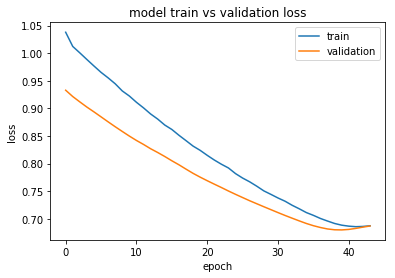

In [1872]:
# Avaliando o Modelo
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss'), 
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [1873]:
print("Loss: ", model2.evaluate(X_valid, y_valid, verbose=0))

Loss:  [0.6870256393962402, 0.5836881755650181]


In [1746]:
from sklearn.metrics import recall_score

In [1874]:
print('Validation Results')
print(recall_score(y_valid,np.round(model2.predict(X_valid)).T[0]))
print('\nTest Results')
print(1 - inaccuracy)
print(recall_score(y_test,np.round(model2.predict(X_test)).T[0]))

Validation Results
0.86158357771261

Test Results
0.6389364161849711
0.9470198675496688


In [1034]:
from sklearn import metrics

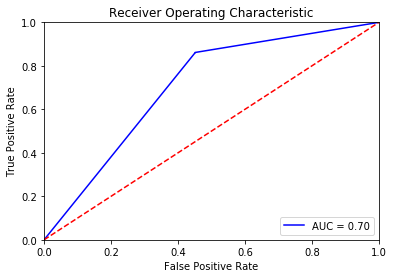

In [1876]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [1878]:
y2_predicted = np.round(model2.predict(X_test)).T[0]
y2_correct = np.array(y_test)

In [1879]:
np.setdiff1d(y2_predicted, y2_correct)

array([], dtype=float32)

In [1880]:
false_neg = 0
false_pos = 0
incorrect = 0
total = len(y_test)
for i in range(len(y_test)):
    if y2_predicted[i] != y2_correct[i]:
        incorrect += 1
        if y2_correct[i] == 1 and y2_predicted[i] == 0:
            false_neg += 1
        else:
            false_pos += 1

inaccuracy = incorrect / total

print('Inacurácia:', inaccuracy)
print('Acurácia:', 1 - inaccuracy)
if incorrect > 0:
    print('Taxa de Falsos Negativos:', false_neg/incorrect)
    print('Taxa de Falsos Positivos:', false_pos / incorrect )    
print('Falsos Negativos/total:', false_neg/total)

Inacurácia: 0.35061271676300576
Acurácia: 0.6493872832369942
Taxa de Falsos Negativos: 0.01688208915853337
Taxa de Falsos Positivos: 0.9831179108414666
Falsos Negativos/total: 0.005919075144508671


In [1885]:
print('Validation Results')
print(recall_score(y_valid,np.round(model2.predict(X_valid)).T[0]))
print('\nTest Results')
print(1 - inaccuracy)
print(recall_score(y_test,np.round(model2.predict(X_test)).T[0]))

Validation Results
0.86158357771261

Test Results
0.6493872832369942
0.9470198675496688


In [1881]:
print(incorrect)

7582


Confusion matrix:
Predicted  False  True  __all__
Actual                         
False      11755  7454    19209
True         128  2288     2416
__all__    11883  9742    21625


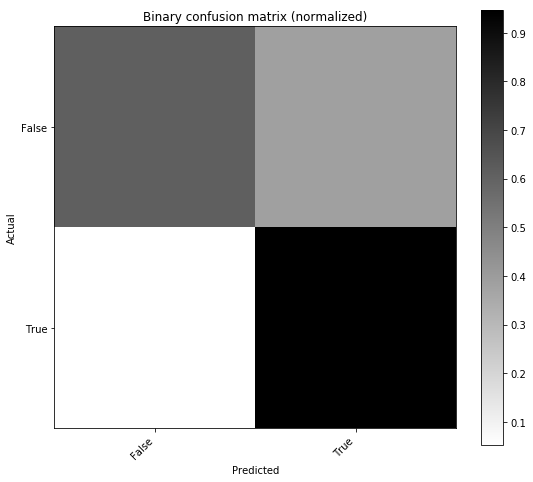

population: 21625
P: 2416
N: 19209
PositiveTest: 9742
NegativeTest: 11883
TP: 2288
TN: 11755
FP: 7454
FN: 128
TPR: 0.9470198675496688
TNR: 0.6119527304909157
PPV: 0.23485937179223978
NPV: 0.9892283093494909
FPR: 0.3880472695090843
FDR: 0.7651406282077602
FNR: 0.052980132450331126
ACC: 0.6493872832369942
F1_score: 0.37637769369962165
MCC: 0.3539193033965275
informedness: 0.5589725980405844
markedness: 0.22408768114173072
prevalence: 0.11172254335260115
LRP: 2.4404755347144604
LRN: 0.08657553077315275
DOR: 28.188975717735442
FOR: 0.010771690650509131


In [1882]:
confusion_matrix2 = ConfusionMatrix(y2_correct, y2_predicted)
print("Confusion matrix:\n%s" % confusion_matrix2)
confusion_matrix2.plot(normalized=True)
plt.show()
confusion_matrix2.print_stats()

### Conclusão
O modelo de Deep Learning conseguiu atingir um excelente índice de acurácia no recall da classe minoritária, demonstrando ser uma ferramenta eficaz na identificação antecipada de pacientes que necessitarão de uma maior atenção da equipe assistencial, por possuir uma alta probabilidade de ocorrência de readmissão.



#### Referencias

Data Science Acabemy: Formação Inteligencia Artificial           
https://www.datascienceacademy.com.br/pages/formacao-inteligencia-artificial

Fator de Qualidade: dados de readmissão hospitalar devem ser informados à ANS   
http://www.ans.gov.br/aans/noticias-ans/qualidade-da-saude/3167-fator-de-qualidade-dados-de-readmissao-hospitalar-devem-ser-informados-a-ans

3 formas únicas de diminuir a readmissão hospitalar       
https://saudebusiness.com/noticias/3-formas-diminuir-readmissao-hospitalar/

Resampling strategies for imbalanced datasets       
https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets

The Right Way to Oversample in Predictive Modeling       
https://beckernick.github.io/oversampling-modeling/
